<a href="https://colab.research.google.com/github/boangri/uai-thesis-notebooks/blob/main/notebooks/DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Q Learning

In [ ]:
!pip install box2d-py

     |████████████████████████████████| 450kB 5.4MB/s 


In [ ]:
!pip install pyvirtualdisplay 
!pip install xvfbwrapper 
!apt-get update 
!apt-get install xvfb

  Created wheel for xvfbwrapper: filename=xvfbwrapper-0.2.9-cp37-none-any.whl size=5009 sha256=8c3b757063c5e050866a04e9acc453756db9cce29ead03cd850d9006911e2e9f
  Stored in directory: /root/.cache/pip/wheels/10/f2/61/cacfaf84b352c223761ea8d19616e3b5ac5c27364da72863f0
Successfully built xvfbwrapper
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Ge

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
import glob 
import io 
import base64 
from IPython.display import HTML 
import time 
from IPython import display as ipythondisplay 
from pyvirtualdisplay import Display 
import gym
from gym import wrappers
from gym import logger as gymlogger 
from gym.wrappers import Monitor 
gymlogger.set_level(40)

## Classes & Functions

In [ ]:
class ReplayBuffer(object):
    def __init__(self, max_size, input_shape, n_actions):
        self.mem_size = max_size
        self.mem_cntr = 0
        self.state_memory = np.zeros((self.mem_size, *input_shape),
                                     dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *input_shape),
                                         dtype=np.float32)

        self.action_memory = np.zeros(self.mem_size, dtype=np.int64)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)

    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = done
        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice(max_mem, batch_size, replace=False)

        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        states_ = self.new_state_memory[batch]
        terminal = self.terminal_memory[batch]

        return states, actions, rewards, states_, terminal

In [ ]:
class DeepQNetwork(nn.Module):
    def __init__(self, lr, input_dims, fc1_dims, fc2_dims, n_actions, chkpt_dir, name):
        super().__init__()
        self.checkpoint_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, name)
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.fc3 = nn.Linear(self.fc2_dims, self.n_actions)
        
        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.loss = nn.MSELoss()
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def save_checkpoint(self):
        print('... saving checkpoint ...')
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        print('... loading checkpoint ...')
        self.load_state_dict(T.load(self.checkpoint_file))

In [ ]:
class EpsilonGreedy():
    def __init__(self, epsilon=1.0, eps_min=0.01, eps_dec=1e-5):
        self.epsilon = epsilon
        self.eps_min = eps_min
        self.eps_dec = eps_dec
        return

    def isGreedy(self):
        return True if np.random.random() > self.epsilon else False

    def decrement(self):
        self.epsilon = self.epsilon - self.eps_dec if self.epsilon > self.eps_min else self.eps_min
        return self.epsilon


In [ ]:
class DQNAgent(object):
    def __init__(self, epsilonGreedy, replayBuffer, evalNetwork, nextNetwork, n_actions, batch_size, gamma=0.99, replace=1000):
        self.gamma = gamma
        self.n_actions = n_actions
        self.input_dims = input_dims
        self.batch_size = batch_size
        self.replace_target_cnt = replace
        self.action_space = [i for i in range(n_actions)]
        self.learn_step_counter = 0

        self.epsilon_greedy = epsilonGreedy
        self.memory = replayBuffer
        self.q_eval = evalNetwork
        self.q_next = nextNetwork

    def choose_action(self, observation):
        if self.epsilon_greedy.isGreedy():
            state = T.tensor([observation], dtype=T.float).to(self.q_eval.device)
            actions = self.q_eval.forward(state)
            action = T.argmax(actions).item()
        else:
            action = np.random.choice(self.action_space)

        return action

    def store_transition(self, state, action, reward, state_, done):
        self.memory.store_transition(state, action, reward, state_, done)

    def sample_memory(self):
        state, action, reward, new_state, done = \
                                self.memory.sample_buffer(self.batch_size)

        states = T.tensor(state).to(self.q_eval.device)
        rewards = T.tensor(reward).to(self.q_eval.device)
        dones = T.tensor(done).to(self.q_eval.device)
        actions = T.tensor(action).to(self.q_eval.device)
        states_ = T.tensor(new_state).to(self.q_eval.device)

        return states, actions, rewards, states_, dones

    def replace_target_network(self):
        if self.learn_step_counter % self.replace_target_cnt == 0:
            self.q_next.load_state_dict(self.q_eval.state_dict())

    def save_models(self):
        self.q_eval.save_checkpoint()
        self.q_next.save_checkpoint()

    def load_models(self):
        self.q_eval.load_checkpoint()
        self.q_next.load_checkpoint()

    def learn(self):
        if self.memory.mem_cntr < self.batch_size:
            return

        self.q_eval.optimizer.zero_grad()

        self.replace_target_network()

        states, actions, rewards, states_, dones = self.sample_memory()
        indices = np.arange(self.batch_size)

        q_pred = self.q_eval.forward(states)[indices, actions]
        q_next = self.q_next.forward(states_).max(dim=1)[0]

        q_next[dones] = 0.0
        q_target = rewards + self.gamma*q_next

        loss = self.q_eval.loss(q_target, q_pred).to(self.q_eval.device)
        loss.backward()
        self.q_eval.optimizer.step()
        self.learn_step_counter += 1

        self.epsilon_greedy.decrement()

In [ ]:
def learn(env, agent, n_games, history_file, freq=10):
    for i in range(n_games):
        score = 0
        done = False
        obs = env.reset()
        steps = 0
        while not done:
            action = agent.choose_action(obs)
            obs_, reward, done, info = env.step(action)
            score += reward
            steps += 1
            agent.store_transition(obs, action, reward, obs_, int(done))
            agent.learn()
            obs = obs_
        scores.append(score)
        eps_history.append(agent.epsilon_greedy.epsilon)

        if (i + 1) % freq == 0:
            avg_score = np.mean(scores[-100:])
            print('episode ', i + 1, 'score %.1f avg score %.1f epsilon %.2f steps %d' %
                    (score, avg_score, agent.epsilon_greedy.epsilon, steps))
        with open(history_file, 'a') as h:   
            h.write("%d,%.2f,%.2f,%d\n" % (i + 1, score, agent.epsilon_greedy.epsilon, steps)) 

In [ ]:
def test(env, agent, episodes=100):
    total = 0.
    for ep in range(episodes):
        score = 0.
        obs = env.reset()
        done = False
        while not done:
            action = agent.choose_action(obs)
            obs, reward, done, _ = env.step(action)
            score += reward
        if (ep + 1) % 10 == 0:
            print("episode: %d Score: %1.f" % (ep+1, score))
        total += score
    print("Average score %.2f" % (total/episodes))

In [ ]:
display = Display(visible=0, size=(1400, 900))
display.start()

def video(env, agent, seed=42):
    env.seed(seed)
    env = wrap_env(env)
    obs = env.reset()
    done = False
    score = 0.
    while not done:
        env.render()
        action = agent.choose_action(obs)
        obs, reward, done, _ = env.step(action)
        score += reward
    env.close()
    print("Score=%.2f" % score)
    show_video()

def show_video():    
    mp4list = glob.glob(os.path.join(dir, 'video/*.mp4'))
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else: 
        print("Could not find video")
    
def wrap_env(env):
    env = Monitor(env, os.path.join(dir, 'video'), force=True)
    return env

In [ ]:
def plot_history(history_file):
    df = pd.read_csv(history_file, header=None, names=('episode', 'score', 'epsilon', 'steps'))
    x = df.episode
    y = df.score
    y1 = np.zeros_like(y)
    for i in range(len(x)):
        y1[i] = np.mean(y[i-100:i])
    eps = df.epsilon
    plt.figure(figsize=(12,12))
    plt.subplot(2, 1, 1)
    plt.scatter(x, y, label='очки')
    plt.plot(x, y1, color='C1', label='среднее за 100')
    plt.ylabel('Очки')
    plt.xlabel('Эпизоды')
    plt.legend()
    plt.grid()
    plt.title(f'История обучения - {env_name} {algo}')
    plt.subplot(2, 1, 2)
    plt.plot(x, eps, color='C2', label='epsilon')
    plt.ylabel('Epsilon')
    plt.xlabel('Эпизоды')
    plt.legend()
    plt.grid()
    plt.title(f'История обучения - {env_name} {algo}')
    plt.show()

In [ ]:
algo='DQN'
home_dir = os.path.join('/content/drive/MyDrive/Thesys', algo)

## LunarLander-v2

In [ ]:
env_name = 'LunarLander-v2'
dir = os.path.join(home_dir, env_name)
history_file = os.path.join(dir, 'history.csv')
!mkdir -p $dir 

In [ ]:
%%time
env = gym.make(env_name)
n_games = 30
scores = []
eps_history = []
lr = 0.0001
input_dims = env.observation_space.shape
n_actions = env.action_space.n

fc1_dims, fc2_dims = 256, 256

epsilonGreedy = EpsilonGreedy(eps_dec=4e-6)

replayBuffer = ReplayBuffer(max_size=10000, input_shape=input_dims, n_actions=n_actions)

evalNetwork = DeepQNetwork(lr=lr, n_actions=n_actions, fc1_dims=fc1_dims, fc2_dims=fc2_dims, input_dims=input_dims, name=env_name + '_' + algo + '_q_eval', chkpt_dir=dir)

nextNetwork = DeepQNetwork(lr=lr, n_actions=n_actions, fc1_dims=fc1_dims, fc2_dims=fc2_dims, input_dims=input_dims, name=env_name + '_' + algo + '_q_next', chkpt_dir=dir)

agent = DQNAgent(epsilonGreedy, replayBuffer, evalNetwork, nextNetwork, n_actions, gamma=0.99, batch_size=32, replace=1000)

episode  10 score -77.8 avg score -205.7 epsilon 1.00 steps 95
episode  20 score -102.5 avg score -167.1 epsilon 0.99 steps 72
episode  30 score -122.3 avg score -153.7 epsilon 0.99 steps 104
CPU times: user 9.3 s, sys: 1.3 s, total: 10.6 s
Wall time: 10.8 s


In [ ]:
!rm -f $history_file
learn(env, agent, n_games, history_file)

RuntimeError: ignored

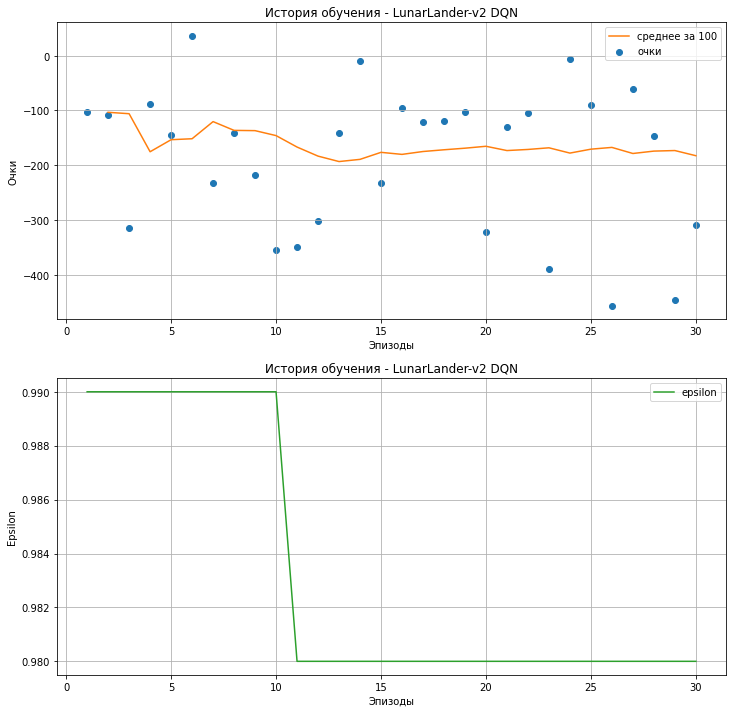

In [ ]:
plot_history(history_file)

In [ ]:
%%time
env = gym.make(env_name)
agent.epsilon_greedy.epsilon = 0.
agent.epsilon_greedy.eps_min = 0.
test(env, agent)

episode: 10 Score: -215
episode: 20 Score: -281
episode: 30 Score: -291
episode: 40 Score: -495
episode: 50 Score: -616
episode: 60 Score: -124
episode: 70 Score: -292
episode: 80 Score: -235
episode: 90 Score: -382
episode: 100 Score: -274
Average score -335.25
CPU times: user 8.86 s, sys: 97.3 ms, total: 8.95 s
Wall time: 8.95 s


In [ ]:
env = gym.make(env_name)
video(env, agent)

RuntimeError: ignored

## CartPole-v1

In [ ]:
env_name = 'CartPole-v1'
dir = os.path.join(home_dir, env_name)
history_file = os.path.join(dir, 'history.csv')
!mkdir -p $dir 

In [ ]:
%%time
env = gym.make(env_name)
n_games = 30
scores = []
eps_history = []
lr = 0.0001
input_dims = env.observation_space.shape
n_actions = env.action_space.n

fc1_dims, fc2_dims = 256, 256

epsilonGreedy = EpsilonGreedy(eps_dec=4e-6)

replayBuffer = ReplayBuffer(max_size=10000, input_shape=input_dims, n_actions=n_actions)

evalNetwork = DeepQNetwork(lr=lr, n_actions=n_actions, fc1_dims=fc1_dims, fc2_dims=fc2_dims, input_dims=input_dims, name=env_name + '_' + algo + '_q_eval', chkpt_dir=dir)

nextNetwork = DeepQNetwork(lr=lr, n_actions=n_actions, fc1_dims=fc1_dims, fc2_dims=fc2_dims, input_dims=input_dims, name=env_name + '_' + algo + '_q_next', chkpt_dir=dir)

agent = DQNAgent(epsilonGreedy, replayBuffer, evalNetwork, nextNetwork, n_actions, gamma=0.99, batch_size=32, replace=1000)

In [ ]:
!rm $history_file
learn(env, agent, n_games, history_file)

In [ ]:
plot_history(history_file)

In [ ]:
%%time
env = gym.make(env_name)
agent.epsilon_greedy.epsilon = 0.
agent.epsilon_greedy.eps_min = 0.
test(env, agent)

In [ ]:
env = gym.make(env_name)
video(env, agent)

Score=500.00


## GrandPrix-v0

In [ ]:
!pip install gym_grand_prix

     |████████████████████████████████| 11.8MB 14.2MB/s 


In [ ]:
import gym_grand_prix

env_name = 'GrandPrix-v0'
dir = os.path.join(home_dir, env_name)
history_file = os.path.join(dir, 'history.csv')
!mkdir -p $dir 

In [ ]:
possible_actions = ((0, 0), (1, .75), (-1, .75), (0, .75), (0, -.75))

In [ ]:
%%time
history_file = os.path.join(dir, 'history.csv')
track = 3
n_rays = 5
env = gym.make(env_name)
options = {
    'nrays': n_rays,
    'seed': track, # задает номер трека
}
env.setOptions(options)
n_episodes = 2000
n_steps = 200
scores = []
eps_history = []
lr = 0.0001
input_dims = env.observation_space.shape
n_actions = 5
algo = 'DQN'
fc1_dims, fc2_dims = 256, 256

epsilonGreedy = EpsilonGreedy(eps_dec=1e-5)

replayBuffer = ReplayBuffer(max_size=10000, input_shape=input_dims, n_actions=n_actions)

evalNetwork = DeepQNetwork(lr=lr, n_actions=n_actions, fc1_dims=fc1_dims, fc2_dims=fc2_dims, input_dims=input_dims, name=env_name + '_' + algo + '_q_eval', chkpt_dir=dir)

nextNetwork = DeepQNetwork(lr=lr, n_actions=n_actions, fc1_dims=fc1_dims, fc2_dims=fc2_dims, input_dims=input_dims, name=env_name + '_' + algo + '_q_next', chkpt_dir=dir)

agent = DQNAgent(epsilonGreedy, replayBuffer, evalNetwork, nextNetwork, n_actions, gamma=0.99, batch_size=32, replace=1000)

for ep in range(n_episodes):
    score = 0
    done = False
    obs = env.reset()
    for step in range(n_steps):
        action = agent.choose_action(obs)
        obs_, reward, done, info = env.step(possible_actions[action])
        done = (step == (n_steps - 1))
        score += reward/n_steps
        agent.store_transition(obs, action, reward, obs_, int(done))
        agent.learn()
        obs = obs_
    scores.append(score)
    eps_history.append(agent.epsilon_greedy.epsilon)

    if (ep + 1) % 10 == 0:
        avg_score = np.mean(scores[-100:])
        print('episode ', ep + 1, 'score %.3f avg score %.3f epsilon %.3f' %
                (score, avg_score, agent.epsilon_greedy.epsilon))
    with open(history_file, 'a') as h:   
        h.write("%d,%.3f,%.3f\n" % (ep + 1, score, agent.epsilon_greedy.epsilon)) 

episode  10 score -0.651 avg score -0.992 epsilon 0.980
episode  20 score -1.228 avg score -1.054 epsilon 0.960
episode  30 score -0.753 avg score -0.992 epsilon 0.940
episode  40 score -0.804 avg score -0.907 epsilon 0.920
episode  50 score -0.616 avg score -0.860 epsilon 0.900
episode  60 score -0.903 avg score -0.787 epsilon 0.880
episode  70 score -0.513 avg score -0.718 epsilon 0.860
episode  80 score -1.177 avg score -0.638 epsilon 0.840
episode  90 score -0.588 avg score -0.618 epsilon 0.820
episode  100 score -0.281 avg score -0.530 epsilon 0.800
episode  110 score 1.271 avg score -0.381 epsilon 0.780
episode  120 score 1.560 avg score -0.192 epsilon 0.760
episode  130 score 0.028 avg score -0.014 epsilon 0.740
episode  140 score 2.195 avg score 0.156 epsilon 0.720
episode  150 score 0.221 avg score 0.324 epsilon 0.700
episode  160 score 2.618 avg score 0.548 epsilon 0.680
episode  170 score 1.624 avg score 0.767 epsilon 0.660
episode  180 score 0.767 avg score 0.917 epsilon 0.

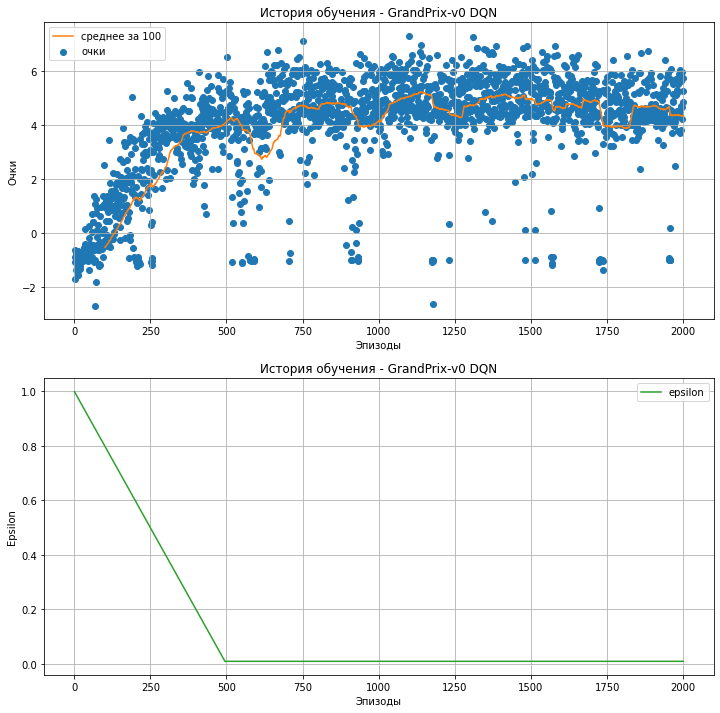

In [ ]:
plot_history(history_file)

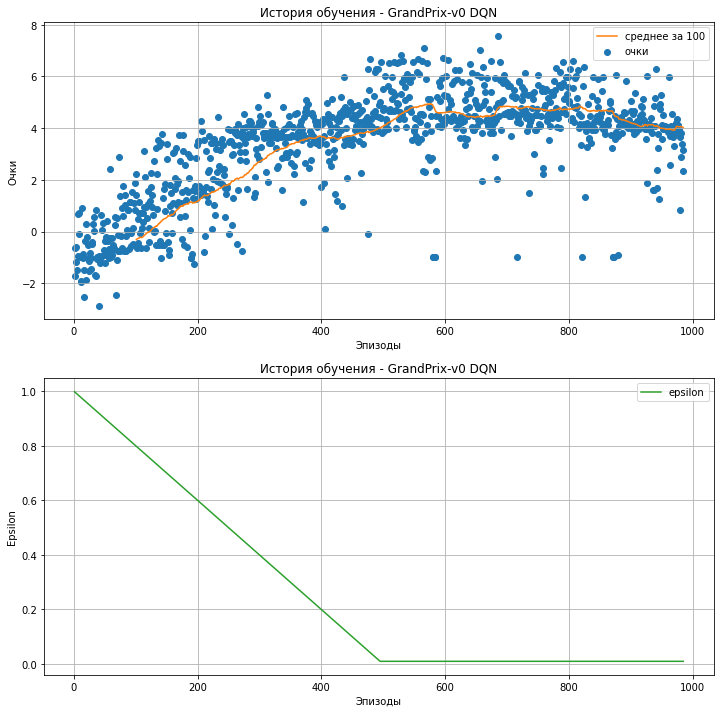

In [ ]:
plot_history(history_file)

In [ ]:
%%time
track = 3
n_rays = 5
env = gym.make(env_name)
options = {
    'nrays': n_rays,
    'seed': track, # задает номер трека
}
env.setOptions(options)

agent.epsilon_greedy.epsilon = 0.
agent.epsilon_greedy.eps_min = 0.
episodes = 100
total = 0.
for ep in range(episodes):
    score = 0.
    obs = env.reset()
    done = False
    for step in range(n_steps):
        action = agent.choose_action(obs)
        obs, reward, done, _ = env.step(possible_actions[action])
        score += reward/n_steps
    if (ep + 1) % 10 == 0:
        print("episode: %d Score: %.3f" % (ep+1, score))
    total += score
print("Average score %.3f" % (total/episodes))

episode: 10 Score: 4.473
episode: 20 Score: 6.067
episode: 30 Score: 4.012
episode: 40 Score: 5.113
episode: 50 Score: 4.709
episode: 60 Score: 4.016
episode: 70 Score: 6.469
episode: 80 Score: 4.875
episode: 90 Score: 5.794
episode: 100 Score: 4.445
Average score 4.740
CPU times: user 1min 56s, sys: 2.01 s, total: 1min 58s
Wall time: 1min 56s


In [ ]:
track = 3
n_rays = 5
env = gym.make(env_name)
options = {
    'nrays': n_rays,
    'seed': track, # задает номер трека
    'display': 1
}
env.setOptions(options)

env = wrap_env(env)
obs = env.reset()
done = False
for ep in range(10):
    score = 0.
    for step in range(n_steps):
        env.render()
        action = agent.choose_action(obs)
        obs, reward, done, _ = env.step(possible_actions[action])
        score += reward/n_steps
env.close()
print("Score=%.3f" % score)
show_video()

Score=4.473


In [ ]:
track = 21
n_rays = 5
env = gym.make(env_name)
options = {
    'nrays': n_rays,
    'seed': track, # задает номер трека
    'display': 1
}
env.setOptions(options)

env = wrap_env(env)
obs = env.reset()
done = False
for ep in range(10):
    score = 0.
    for step in range(n_steps):
        env.render()
        action = agent.choose_action(obs)
        obs, reward, done, _ = env.step(possible_actions[action])
        score += reward/n_steps
env.close()
print("Score=%.3f" % score)
show_video()

Score=2.048


#End
